# Batch Mode Speaker Verificaiton  

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ['KALDI_ROOT'] = "/dataset/muncok/kaldi/"

In [13]:
from utils import key2df, df2dict

keys = pickle.load(open("xvector_embeds/sv_keys.pkl", "rb"))
key_df = key2df(keys)
id2idx, idx2id = df2dict(key_df) 

In [14]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error, compute_eer

## Run Trial - Score fusion

In [15]:
from batch_sv_system_utils import run_trial, plot_score 

In [75]:
# sv_embeds = np.load("xvector_embeds/sv_embeds.npy")
sv_embeds = np.load("../sv_system/embeddings/voxc2_fbank64_voxc2untied_tdnn7_100f_embeds/sv_embeds.npy")
# sv_embeds = np.load("xvector_tdnn7_embeds/sv_embeds.npy")

In [76]:
trial = pickle.load(open("trials/enr306/enr306_closedset_big/FS_9//trials.pkl", "rb"))
# trial_info = pickle.load(open("trials/enr306/enr306_closedset_big/FS_5/trial_info.pkl", "rb"))
enr_spk, enr_ids, test_trial, adapt_trial, ood_trial = trial[2]

In [77]:
enr_ids

['id11027-IOcz7BhiwWI-00003',
 'id11027-1rDT7SwheMo-00025',
 'id11027-1rDT7SwheMo-00012']

In [78]:
adapt_trial[0]

['id10300-SQzWyPhRqmk-00012',
 'id11027-Xrj5oQtodCc-00017',
 'id10300-xiFC4HwUcww-00002',
 'id10300-2cAiIYHfon0-00020',
 'id10708-u2zY-qUlgK4-00005',
 'id11027-E5ojBNZCK60-00002',
 'id10708-3_TLa8mO_iM-00006',
 'id10278-Pp-rAswo4Xg-00005',
 'id10278-rgcxEM5jOc4-00012',
 'id10708-iNhHCcePFPI-00017',
 'id10300-Xroutc-3_SU-00002',
 'id11027-TCbwEu15P1Q-00001',
 'id10399-mjZB3mbU9gM-00003',
 'id11027-IOcz7BhiwWI-00006',
 'id11027-1rDT7SwheMo-00008',
 'id10825-hn22gh-kpds-00004',
 'id11027-TCbwEu15P1Q-00004',
 'id10278-_a9CIdlTOr8-00004',
 'id10278-WZ6rcARSDqs-00001',
 'id10912-EnAmuPInAvs-00001',
 'id10912-csbEEsKuRO8-00008',
 'id11027-zweVa28Ez6c-00003',
 'id11027-5XMHhGyJpHY-00004',
 'id10278-Pp-rAswo4Xg-00013',
 'id10300-AsHhZ_bnpQg-00009',
 'id10825-lK0WwGfThto-00006',
 'id11027-1rDT7SwheMo-00026',
 'id10708-Ku-DlbZw2ik-00003',
 'id11027-Xrj5oQtodCc-00019',
 'id11027-7J4N-z-ptUk-00012',
 'id11027-uNKHElTLfNA-00009',
 'id11027-1rDT7SwheMo-00005',
 'id11027-eVrZxU84G0U-00001',
 'id10399-

In [83]:
vT = 0.62
eT = 0.85
neT = 0.45

err=0.4891, fpr=0.9783, fnr=0.0000, thres=0.6200
err=0.4891, eer=0.1739, fpr=0.9783, fnr=0.0000, thres=0.6200


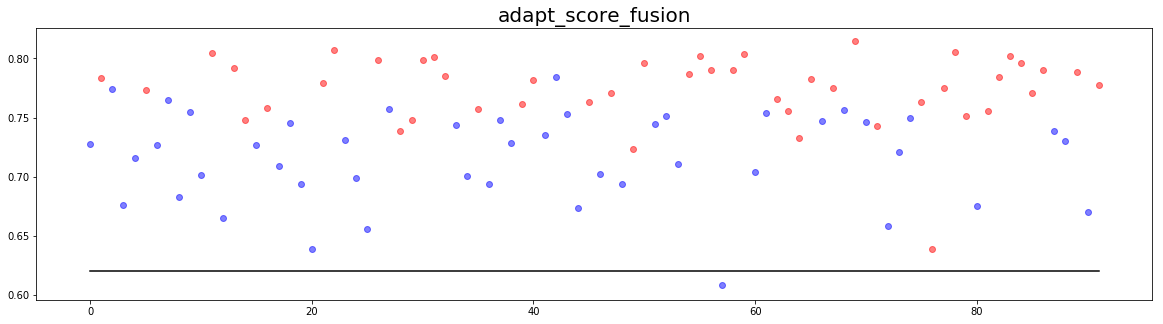

In [84]:
enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx)
# enr_embeds = enr_embeds[0:1]
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, id2idx)
adapt_score_fusion = run_trial(enr_embeds, adapt_embeds, adapt_trial[1], threshold=vT)
plot_score(adapt_score_fusion, adapt_trial[1], vT, "adapt_score_fusion")

In [85]:
adapt_enr_idx = np.nonzero(adapt_score_fusion > eT)
adapt_enr_embeds = adapt_embeds[adapt_enr_idx]
# adapt_enr_embeds = adapt_embeds[adapt_trial[1]]
adapt_enr_acc = np.array(adapt_trial[1])[adapt_enr_idx].mean()
print("n_adapted:{}, adapt_acc:{:.3f}".format(len(adapt_enr_idx[0]), adapt_enr_acc))

n_adapted:0, adapt_acc:nan


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [86]:
neg_adapt_enr_idx = np.nonzero(adapt_score_fusion < neT)
neg_adapt_enr_embeds = adapt_embeds[neg_adapt_enr_idx]
neg_adapt_enr_acc = (1-np.array(adapt_trial[1]))[neg_adapt_enr_idx].mean()
print("n_adapted:{}, neg_adapt_acc:{:.3f}".format(len(neg_adapt_enr_idx[0]), adapt_enr_acc))

n_adapted:0, neg_adapt_acc:nan


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [87]:
### score fusion
total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)
### feat_fusion
# total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0).mean(0, keepdims=True)

err=0.4945, fpr=0.9890, fnr=0.0000, thres=0.6200
err=0.4945, eer=0.1868, fpr=0.9890, fnr=0.0000, thres=0.6200


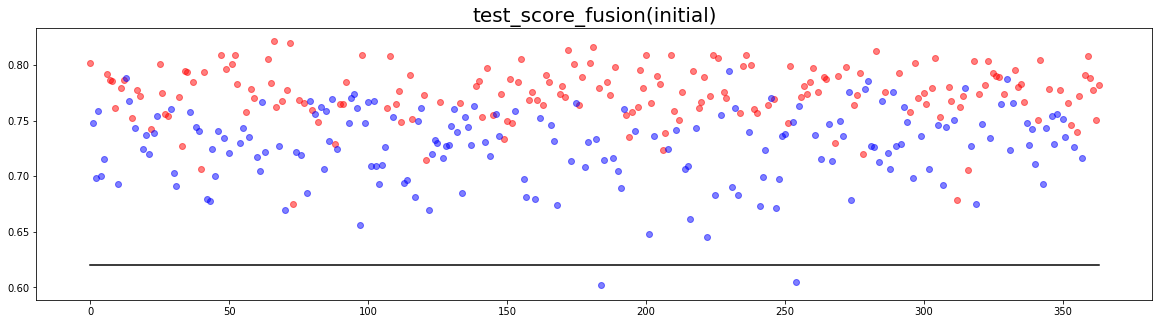

--------------------------------------------------
err=0.4945, fpr=0.9890, fnr=0.0000, thres=0.6200
err=0.4945, eer=0.1868, fpr=0.9890, fnr=0.0000, thres=0.6200


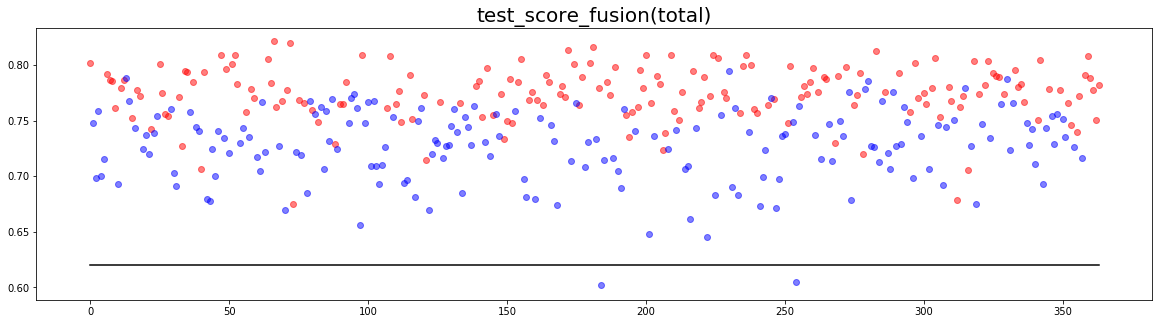

--------------------------------------------------
neg_adapted enr_embeds


ValueError: zero-size array to reduction operation maximum which has no identity

In [88]:
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx)
test_score_fusion = run_trial(enr_embeds, test_embeds, test_trial[1], threshold=vT)
plot_score(test_score_fusion, test_trial[1], vT, "test_score_fusion(initial)")
print("-"*50)
test_score_fusion = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT)
plot_score(test_score_fusion, test_trial[1], vT, "test_score_fusion(total)")
print("-"*50)
print("neg_adapted enr_embeds")
test_score_fusion = run_trial(total_enr_embeds, test_embeds, test_trial[1], threshold=vT,
                              neg_embeds=neg_adapt_enr_embeds)
# plot_score(test_score_fusion, test_trial[1], vT, "test_score_fusion")

initial enr_embeds
err=0.0543, fpr=0.0543, fnr=0.0000, thres=0.6200
err=0.0543, eer=0.0000, fpr=0.0543, fnr=0.0000, thres=0.6200


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


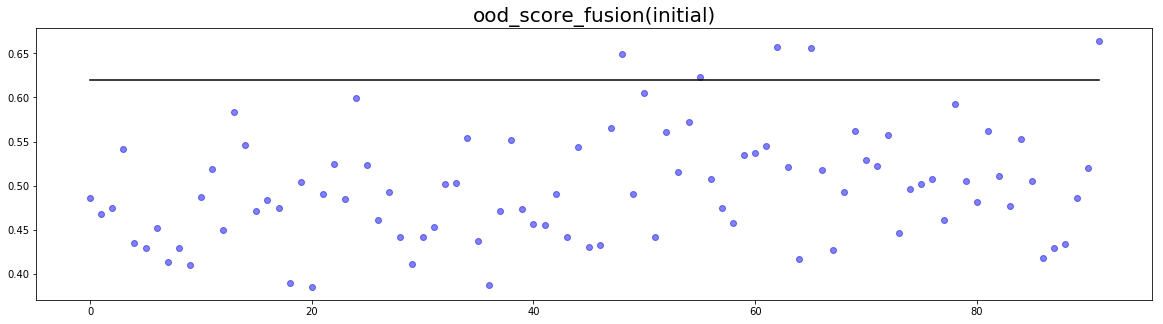

--------------------------------------------------
initial+adapted enr_embeds
err=0.0543, fpr=0.0543, fnr=0.0000, thres=0.6200
err=0.0543, eer=0.0000, fpr=0.0543, fnr=0.0000, thres=0.6200


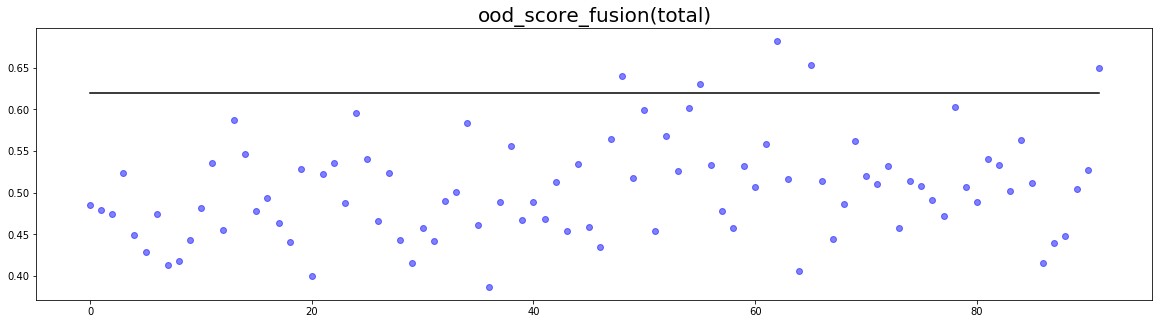

--------------------------------------------------
initial+adapted+neg_adapted enr_embeds
err=0.0543, fpr=0.0543, fnr=0.0000, thres=0.6200


In [72]:
### total_enr_embeds = np.concatenate([enr_embeds, adapt_enr_embeds], axis=0)
ood_embeds = get_embeds(ood_trial[0], sv_embeds, id2idx)
print("initial enr_embeds")
ood_score_fusion = run_trial(enr_embeds, ood_embeds, ood_trial[1], threshold=vT)
plot_score(ood_score_fusion, ood_trial[1], vT, "ood_score_fusion(initial)")
print("-"*50)
print("initial+adapted enr_embeds")
ood_score_fusion = run_trial(total_enr_embeds, ood_embeds, ood_trial[1], threshold=vT)
plot_score(ood_score_fusion, ood_trial[1], vT, "ood_score_fusion(total)")
print("-"*50)
print("initial+adapted+neg_adapted enr_embeds")
ood_score_fusion = run_trial(total_enr_embeds, ood_embeds, ood_trial[1], threshold=vT, neg_embeds=neg_adapt_enr_embeds)
# plot_score(ood_score_fusion, ood_trial[1], vT, "ood_score_fusion")